In [3]:
!pip install qiskit

     |████████████████████████████████| 5.3 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 8.6 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 32.3 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 31.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 634 kB 24.6 MB/s eta 0:00:01
     |████████████████████████████████| 7.9 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 236 kB 30.8 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 23.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 23.3 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 86 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████|

    Running setup.py install for python-constraint ... done
    Running setup.py install for multitasking ... done
    Running setup.py install for yfinance ... done
    Running setup.py install for fastdtw ... done
    Running setup.py install for docplex ... done
    Running setup.py install for dlx ... done
    Running setup.py install for qiskit ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
!pip install pylatexenc

     |████████████████████████████████| 162 kB 6.1 MB/s eta 0:00:01
Using legacy 'setup.py install' for pylatexenc, since package 'wheel' is not installed.
    Running setup.py install for pylatexenc ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [8]:
##Importing the required libraries
import numpy as np
import math

from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit import Aer, execute

from qiskit.circuit.library import ZGate     #The single-qubit Pauli-Z gate (𝜎𝑧)
from qiskit.quantum_info import Operator
from qiskit.providers.aer.backends import statevector_simulator, qasm_simulator
from qiskit.visualization import plot_state_city, plot_histogram

In [19]:
def targets(bitsize):
    state1 = ""
    state2 = ""
    bits = ["0", "1"]
    for i in range(bitsize):
        state1 += bits[i%2]
        state2 += bits[1-(i%2)]
    return state1, state2

In [20]:
def state_bin(vector, bitsize):
    state = ""
    for num in vector:
        state += bin(num)[2:].rjust(bitsize,'0')
    return state[::-1]

In [21]:
def controlZ(bitsize):
    ctrlZ = QuantumCircuit(bitsize)
    g1 = ZGate().control(num_ctrl_qubits=bitsize, ctrl_state=targets(bitsize)[0])
    g2 = ZGate().control(num_ctrl_qubits=bitsize, ctrl_state=targets(bitsize)[1])
    return g1, g2

In [22]:
def groversDiffuser(n):
    s = np.array([[1.0/np.sqrt(2**n)] for i in range(2**n)])
    op = np.matmul(s, s.T)
    U_S = Operator((2*op)-np.identity(2**n))
    
    return U_S

In [23]:
def fanout(n, bitsize):
    address = QuantumRegister(n, 'add')
    tau = QuantumRegister(2**n, 't')
    
    circ = QuantumCircuit(address, tau)
    
    circ.x(tau[0])
    circ.cx(address[n-1], tau[1])
    circ.cx(tau[1], tau[0])
    
    for i in range(1, n):
        for j in range(2**i):
            circ.ccx(address[n-i-1], tau[j], tau[j+2**i])
        for k in range(2**i):
            circ.cx(tau[k+2**i], tau[k])
    
    gate = circ.to_gate()
    gate.name = "Fanout"
    
    return gate

In [24]:
def q_ram(vector):
    
    #Gathering information from given vector, making sure that a circuit has atleast minimum 8 address states
    if len(vector)<=4:
        for i in range(len(vector), 8):
            vector.append(0)

    n = math.ceil(math.log(len(vector), 2))

    if len(vector) < 2**n:
      for i in range(len(vector), 2**n):
        vector.append(0)
    vector.reverse()
    bitsize = len(bin(max(vector))) - 2
  
    #Creating the quantum circuit
    address = QuantumRegister(n, 'add')
    tau = QuantumRegister(2**n, 't')
    memory = QuantumRegister(bitsize*len(vector), 'mem')
    # output = QuantumRegister(bitsize, 'op')
    classicalBit = ClassicalRegister(n, 'clBit')
    
    circ = QuantumCircuit(address,tau,memory,classicalBit)
    
    #Initialising the input state of the vector
    state = state_bin(vector, bitsize)
    for count, i in enumerate(state):
        if i == "1":
            circ.x(memory[count])
            
    #Initialise the address state to all possible states
    circ.h(address[0:n])
    
    #Defining the fanout gate and fanoutGate_inverse (to remove entanglement)
    fanoutGate = fanout(n, bitsize)
    fanout_inverse = fanoutGate.inverse()
    temp=[]
    temp.append(address[:])
    temp.append(temp[:])
    
    #Append the fanout gate to the circuit
    circ.append(fanoutGate, range(n+2**n))

    #Now, as in the qram we need to query the memory states with toffoli gates
    # for i in range(2**n):
    #     for j in range(bitsize):
    #         circ.ccx(tau[i], memory[bitsize*i+j], output[j])
    #     circ.barrier()
    
    #Get the oracle(controlZGates) and the diffuser 
    cz1, cz2 = controlZ(bitsize)
    groversDiff = groversDiffuser(n)
    
    #apply the oracle to get negative states of the required address locations
    for i in range(2**n):
        qubits=[]
        for j in range(bitsize):
            qubits.append(memory[bitsize*i+j])
        qubits.append(tau[i])
        circ.append(cz1, qubits)
        circ.append(cz2, qubits)
        circ.barrier()
        
    # Applying the fanout to the circuit again to remove entanglement
    circ.append(fanout_inverse, range(n+2**n))
    
    #applying the grovers diffuser to get the final results
    circ.append(groversDiff, range(n))
    circ.barrier()
    
    #Apply the measurement to the circuit
    for i in range(n):
        circ.measure(address[i], classicalBit[i])
    
    
    return circ

In [25]:
def measurementOutcome(circ):
  backend = Aer.get_backend("qasm_simulator")
  job = execute(circ, backend, shots = 1024)
  res = job.result()
  counts = res.get_counts()
  return counts

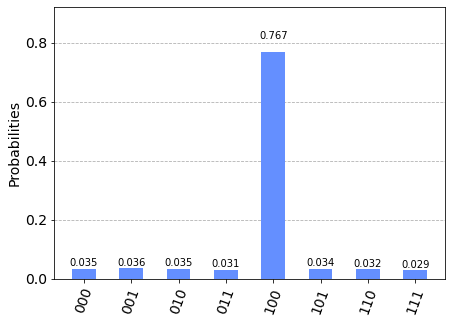

In [26]:
qcirc = q_ram([1,5,7,0])
counts = measurementOutcome(qcirc)
plot_histogram(counts)